In [1]:
# Compatibility layer between Python 2 and Python 3

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import os
import sys
import pandas as pd

import gzip

import threading

In [2]:
%%time
#시간 측정 

import boto3
import time
from time import gmtime, strftime
from sagemaker import get_execution_role

import prepro

import importlib
role = get_execution_role()

region = boto3.Session().region_name
bucket='sndv.analysisdata' # put your s3 bucket name here, and create s3 bucket

s3 = boto3.resource('s3')

CPU times: user 858 ms, sys: 122 ms, total: 980 ms
Wall time: 1.63 s


In [3]:
## 이건 policy

iam = boto3.client('iam')

rr = iam.get_policy(PolicyArn = 'arn:aws:iam::aws:policy/AdministratorAccess')
print(rr)

{'Policy': {'PolicyName': 'AdministratorAccess', 'PolicyId': 'ANPAIWMBCKSKIEE64ZLYK', 'Arn': 'arn:aws:iam::aws:policy/AdministratorAccess', 'Path': '/', 'DefaultVersionId': 'v1', 'AttachmentCount': 1, 'PermissionsBoundaryUsageCount': 0, 'IsAttachable': True, 'Description': 'Provides full access to AWS services and resources.', 'CreateDate': datetime.datetime(2015, 2, 6, 18, 39, 46, tzinfo=tzlocal()), 'UpdateDate': datetime.datetime(2015, 2, 6, 18, 39, 46, tzinfo=tzlocal())}, 'ResponseMetadata': {'RequestId': 'b811e9df-90ae-44e0-810d-3b51b2b93378', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'b811e9df-90ae-44e0-810d-3b51b2b93378', 'content-type': 'text/xml', 'content-length': '837', 'date': 'Wed, 05 Feb 2020 00:20:38 GMT'}, 'RetryAttempts': 0}}


In [4]:
MODEL_NAME = 'life-threatening_arrhythmias'
FILE_DATASET = 'life-threatening_arrhythmias.csv'
PATH_DATASET =  "s3://sndv.analysisdata/dataset/life-threatening_arrhythmias/"

prefix = 'dataset/life-threatening_arrhythmias'
logtxt = ""

In [5]:
import s3fs
df = pd.read_csv('s3://sndv.analysisdata/dataset/life-threatening_arrhythmias/life-threatening_arrhythmias.csv')


In [51]:
# Define column name of the label vector
LABEL = "alarm_encoded"

# 스크립트에 있음 
df = prepro.encoding(df)

# print(df)

     record  alarm_label               arrhythmia  lead_ii_max  lead_ii_min  \
0     a103l        False                 Asystole      1.84435     -0.79219   
1     a104s        False                 Asystole      2.01575     -0.89022   
2     a105l        False                 Asystole      1.97200     -0.77429   
3     a109l        False                 Asystole      1.96848     -0.94543   
4     a134s        False                 Asystole      5.09194     -5.09495   
5     a142s         True                 Asystole      0.64527     -0.17663   
6     a145l        False                 Asystole      0.78016     -1.28306   
7     a161l         True                 Asystole      0.30606     -1.44913   
8     a163l        False                 Asystole      4.55699     -2.44400   
9     a165l        False                 Asystole      3.21308     -1.90748   
10    a167l         True                 Asystole      0.50279     -0.04917   
11    a170s        False                 Asystole   

In [7]:
# %%

# Differentiate between test set and training set
series_record = df['record']
series_record = series_record.drop_duplicates(keep='last')
#

series_train_data, series_validation_data, series_test_data = prepro.series_train_test_split(series_record)

In [8]:
# Python 3.4 이상이라면 당신은 importlib.reload 를 사용할 수 있습니다.

# 아래 함수 내에서 numpy 로 전환하는데 그럴게 아니라 바로 datafrmae 형태로 받아오는게 효율적임
# 나중에 수정 할 것 

x_train, y_train = prepro.create_segments_and_labels(PATH_DATASET,
                                              df,
                                              series_train_data,
                                              LABEL)

# %%

In [9]:
x_validation, y_validation = prepro.create_segments_and_labels(PATH_DATASET,
                                                         df,
                                                         series_validation_data,
                                                         LABEL)

In [10]:
np.savez('./train', data = x_train, label = y_train)
np.savez('./validation',data = x_validation, label = y_validation)

In [11]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix,'train/train.npz')).upload_file('train.npz')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix,'validation/validation.npz')).upload_file('validation.npz')

In [12]:
from sagemaker.tensorflow import TensorFlow

# 컨테이너의 환경변수 섲어 

# 도커파일 = 서버 운영 기록 코드화
# 도커 이미지 = 도커파일 + 실행 시점
# 도커 컨테이너 = 도커 이미지 + 환경변수 


tf_estimator = TensorFlow(entry_point = 'tensorScript.py',
                         role = role,
                         train_instance_count = 1,
                         train_instance_type = 'ml.p3.2xlarge',
                         framework_version = '1.12',
                         py_version = 'py3',
                         script_mode = True,
                         hyperparameters = {
                             'epochs' : 2,
                             'batch-size' : 250,
                             'learning-rate' : 0.01
                         },
                         metric_definitions=[ # 지표 설정 
                           
                           {'Name': 'validation:loss', 'Regex': 'val_loss: ([0-9\\.]+)'},
                           {'Name': 'validation:acc', 'Regex': 'val_acc: ([0-9\\.]+)'}, 
                           {'Name': 'acc', 'Regex': 'acc: ([0-9\\.]+)'},
                           {'Name': 'loss', 'Regex': 'loss: ([0-9\\.]+)'}
                        ]
                         )


# / opt / ml / input / data /   --> 이런건 컨테이너 내부 디렉토리임 defalut 설정이 되있으며 내가 건드리는게 아님
#나는 데이터를 지정해즈면 알아서 거기에 데이터가 저장됨 그리고 훈련 종료시 output data 를 제외한 모든게 삭제됨 

tf_estimator.fit({'training' : os.path.join(PATH_DATASET,'train'), 
                  'validation' : os.path.join(PATH_DATASET,'validation')})

training_job_name = tf_estimator.latest_training_job.job_name

2020-02-05 00:26:05 Starting - Starting the training job...
2020-02-05 00:26:08 Starting - Launching requested ML instances......
2020-02-05 00:27:10 Starting - Preparing the instances for training......
2020-02-05 00:28:22 Downloading - Downloading input data...
2020-02-05 00:28:59 Training - Training image download completed. Training in progress..2020-02-05 00:29:03,048 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-02-05 00:29:03,440 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training",
        "validation": "/opt/ml/input/data/validation"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "batch-size": 250,
        "learning-rate": 0.01,
        "model_dir": "s3://sagemake


2020-02-05 00:29:33 Uploading - Uploading generated training model
2020-02-05 00:29:33 Completed - Training job completed
2020-02-05 00:29:23,222 sagemaker-containers INFO     Reporting training SUCCESS
Training seconds: 71
Billable seconds: 71


### CLI 를 통해서 로그 데이터 버킷으로 출력하는것 

현재는 권한 설정을 맞춰준 상태입니다. 
한번만 맞춰주면 가능합니다. 

1. 엑세스키와 시크릿키가 필요합니다.
2. 그 후 aws configure 명령을 통하여 구성을 해줍니다.
3. 그 다음 버킷 권한을 설정해줘야 하는데 cli 를 통하여 하려면 외부에서 policy.json 파일을 만들어서 인스턴스로 가져온 다음 
aws s3api put-bucket-policy --bucket my-exported-logs --policy file://policy.json 이런 명령어로 버킷 권한을 설정할 수 있습니다. 

json 파일 형식은 https://docs.aws.amazon.com/ko_kr/AmazonCloudWatch/latest/logs/S3ExportTasks.html 이곳에 있지만 doc와 다르게 
아래 PutObjectArl 이것도 설정해줘야합니다.

아래 실행하는 명령어로 s3 버킷에 가져옵니다. log-group-name 은 cloudwatch 가면 있고 prefix 는 어떤 로그 스트림을 설정할 것인지
from to 는 utc 기준 ms 입니다. destination 은 버킷입니다. 버킷 이름만 써도 접근 가능합니다. (동일 계정일시) 
destination-prefix 는 버킷 내에 저장되는 폴더입니다. (없을 시 생성)


### BOTO 3 를 통한 방법

기존 만든 권한이 존재한다는 가정 
권한 설정은 위 CLI 를 통하여 진행
해당 profile_name session 을 통하여 임시 권한을 받아온 후 진행

In [13]:
from datetime import datetime
from time import mktime, localtime

def utctime():
        
    current = datetime.now().timetuple()
    utc = int(mktime(current)*10000)

    return utc

In [14]:
def log(training_job_name):
    
    
    session = boto3.Session(profile_name = 'northstar')
    cloudwatch = session.client('logs')
    # cloud watch client x 
# logs client

    # 현재 권한 정보 출력 
    # print(session.client('sts').get_caller_identity())

    # UTC TIME 
   
    current = datetime.now().timetuple()
    utc = int(mktime(current)*1000)
    logGroupName = '/aws/sagemaker/TrainingJobs'
    logBucketName = 'seerstrainingjoblog'
    logBucketPrefix = 'logdata'
    
    while True:
        response = cloudwatch.create_export_task(
            taskName = 'logExport',
            logGroupName = logGroupName,
            logStreamNamePrefix = training_job_name,
            fromTime = 0,
            to = utc,
            destination = logBucketName,
            destinationPrefix = logBucketPrefix
        )

        taskId = response['taskId']

        logStreamInfo = cloudwatch.describe_log_streams(logGroupName = logGroupName,
                                            logStreamNamePrefix = training_job_name,
                                            )
        logStreamName = logStreamInfo['logStreams'][0]['logStreamName']

        # default path 가 logStreamName으로 형성되는데 이상하게 조금 다르게 형성됩니다.
        # 아마 logStreamName 에 /가 들어가기 때문에 s3 bucket에선 쓸수 없어서 -로 바꿔서 생성하는 것 같습니다.
        # default 값을 바꾸는게 베스트지만 우선 replace 로 값을 수정하여 사용하겠습니다. xxxxx

        logStreamReplace = logStreamName.replace('/','-') 

        logPrefix = 'logdata/{}/{}/000000.gz'.format(taskId,logStreamReplace)



        ## 왠진 모르겠지만 같은 셀에서 s3 다운로드하면 진행이 안됩니다.
        ##  이유 파악할 것 


        # sleeep 을 안걸면  
        # s3 에서 다운받는게 s3로 export 되는 것 보다 먼저 실행되기 때문에 sleep 걸어줍니다. 
        time.sleep(2)


    
        try:
             boto3.Session().resource('s3').Bucket('seerstrainingjoblog').Object(logPrefix).download_file('log.gz')
        except:
            time.sleep(60)
            print('cloudWatch data delay...')
        else:
            break;

   
    with gzip.open('log.gz','rb') as f:
        log = f.read()

    # 현재 byte 타입 
    global logtxt
    logtxt = log.decode()
    
    regexvalue = regexLog(logtxt)
    plot(regexvalue)
    
    

In [15]:
import re
def regexLog(log):
    regex = ['acc','val_loss','val_acc','loss']
    regexvalue = {'acc': 'acc: ([0-9\\.]+) - val', 'val_loss':'val_loss: ([0-9\\.]+)',
                  'val_acc':'val_acc: ([0-9\\.]+)', 'loss' : 'step - loss: ([0-9\\.]+)'}
    for i in regex:
        p = re.compile(regexvalue[i])
        regexvalue[i] = list(map(float,p.findall(log)))
        
    return regexvalue

In [16]:
def plot(regexvalue):
    # import matplotlib.pyplot as plt
    %matplotlib inline

    plt.figure(figsize=(8, 4))
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')


    plt.plot(regexvalue['acc'], 'g' , label = 'Accuracy')
    plt.plot(regexvalue['loss'], 'r', label = 'loss')


    plt.plot(regexvalue['val_acc'], 'g' , label = 'Validation_Acc', linestyle = '--', linewidth = 3.0)
    plt.plot(regexvalue['val_loss'], 'r', label = 'Validation_loss', linestyle = '--', linewidth = 3.0)


    plt.grid()
    plt.legend()

    plt.show()
    

In [205]:
## log boto3 말고 cloudwatch 에서 put_metric_data 살펴보기
# 지표를 설정하는 것인데 초단위로 변경할 수 있는 기능이 있는 것 같은데 이럴때 쓰는게 맞는지 알아볼것 

# client = boto3.client('cloudwatch')


cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...


### 1분 단위로 요약한 그래프 

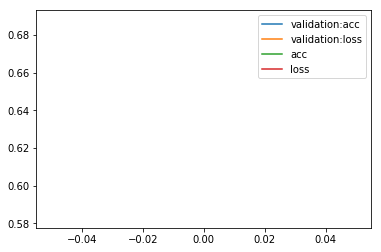

In [17]:
# 내부적으로 1분단위로 요약
# period 는 초단위가 맞지만 그 이하로 내려도 변화 x  이미 1분 단위 요약 데이터 이기 떄문 

%matplotlib inline
import matplotlib.pyplot as plt

from sagemaker.analytics import TrainingJobAnalytics

metric_name = ['validation:acc','validation:loss','acc','loss']

metrics_dataframe  = TrainingJobAnalytics(training_job_name = training_job_name, metric_names = metric_name, period = 1).dataframe()


for group_name in metric_name:
    sub = metrics_dataframe[metrics_dataframe['metric_name'] == group_name]
    plt.plot(sub.timestamp,sub.value)
    

plt.legend(metric_name)
plt.show()

### 정규 표현식을 통해 log 에서 원하는 정보 출력후 형변환 

cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...


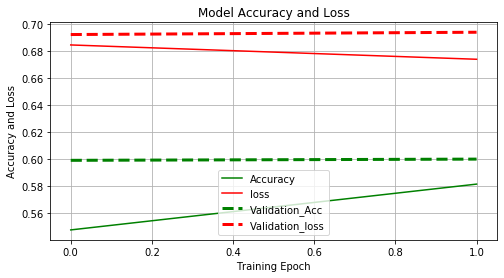

cloudWatch data delay...
cloudWatch data delay...
cloudWatch data delay...


In [203]:
# t = threading.Thread(target = log, args = (training_job_name,))
# t.start()
# t.join()

# 대략 15분 소요 
log(training_job_name)

#코드 정리하면서 함수화 후 스레드


# HPO

## 노트북 인스턴스 내에서 진행 되는 것이 아님 


In [18]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperParameter_ranges = {
    'epochs': IntegerParameter(100, 1000),
    'learning-rate' : ContinuousParameter(0.001, 0.2, scaling_type = 'Logarithmic'),
    'batch-size' : IntegerParameter(32, 1024),
    'dropout' : ContinuousParameter(0.2, 0.6)
}

objective_metric_name = 'validation:acc'
objective_type = 'Maximize'



 


# 하이퍼파라미터 지표에는 val_acc 가 반드시 들어가야하는듯 
# 아닌가 objective_metric_name에 속한게 반드시 들어가야하는 건가?
# 맞네 제네도 objective_metric_name 이걸 지표로해서 측정해야하니까 반드시 포함해야하는거네

metric_definitions = [{'Name' : 'validation:acc', 'Regex' : 'val_acc: ([0-9\\.]+)'},
                      {'Name': 'validation:loss', 'Regex': 'val_loss: ([0-9\\.]+)'},
                      {'Name': 'acc', 'Regex': 'acc: ([0-9\\.]+)'},
                      {'Name': 'loss', 'Regex': 'loss: ([0-9\\.]+)'}]

tuner = HyperparameterTuner(tf_estimator, 
                           objective_metric_name,
                           hyperParameter_ranges,
                           metric_definitions = metric_definitions,
                           max_jobs = 30,
                           max_parallel_jobs = 2,
                           objective_type = objective_type)

In [19]:
tuner.fit({'training' : os.path.join(PATH_DATASET,'train'), 'validation' : os.path.join(PATH_DATASET,'validation')})

In [40]:

## 상태 확인 
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName = tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [42]:
job_count = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName = tuner.latest_tuning_job.job_name)['TrainingJobStatusCounters']['Completed']

print(job_count)

30


In [43]:
import sagemaker

tuner2 = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.job_name)
cc = tuner2.dataframe()

print(cc[['batch-size','dropout','epochs','learning-rate','FinalObjectiveValue']])

    batch-size   dropout  epochs  learning-rate  FinalObjectiveValue
0         32.0  0.600000   902.0       0.048255               0.6807
1         64.0  0.600000   925.0       0.023730               0.6738
2         55.0  0.470619   904.0       0.009686               0.6721
3         33.0  0.600000   530.0       0.148221               0.6943
4        379.0  0.598085  1000.0       0.029404               0.6866
5         36.0  0.600000   902.0       0.048255               0.6943
6         75.0  0.529959   951.0       0.067876               0.7012
7        429.0  0.590468   923.0       0.004207               0.6986
8         47.0  0.593132   678.0       0.133786               0.6284
9         37.0  0.597132   676.0       0.141066               0.6909
10        37.0  0.597132   687.0       0.141066               0.6909
11       969.0  0.438819   809.0       0.138616               0.6122
12        57.0  0.597132   687.0       0.126883               0.7089
13       249.0  0.520858   695.0  

In [ ]:
print(tuner.best_training_job())
print(tuner.latest_tuning_job.job_name)

In [44]:
import time

tuner_endpoint_name = 'hp-tf-'+ time.strftime("%Y-%m-%d",time.gmtime())
tf_endpoint_name = 'tf-'+ time.strftime("%Y-%m-%d",time.gmtime())

In [ ]:
tf_predictor = tf_estimator.deploy(initial_instance_count = 1,
                                  instance_type = 'ml.c5.large',
                                  accelerator_type = 'ml.eia1.medium',
                                  endpoint_name= tf_endpoint_name)

In [45]:
tuner_predictor = tuner.deploy(initial_instance_count = 1, 
                                        instance_type = 'ml.c5.large',
                                        accelerator_type = 'ml.eia1.medium',
                                        endpoint_name = tuner_endpoint_name)

2020-02-05 01:52:43 Starting - Preparing the instances for training
2020-02-05 01:52:43 Downloading - Downloading input data
2020-02-05 01:52:43 Training - Training image download completed. Training in progress.
2020-02-05 01:52:43 Uploading - Uploading generated training model
2020-02-05 01:52:43 Completed - Training job completed2020-02-05 01:47:21,342 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-02-05 01:47:21,343 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value validation:acc to Json.
Returning the value itself
2020-02-05 01:47:21,371 sagemaker_tensorflow_container.training INFO     Appending the training job name to model_dir: s3://sagemaker-ap-northeast-2-387366037097/sagemaker-tensorflow-scriptmode-2020-02-05-00-26-04-482/model/sagemaker-tensorflow-200205-0051-015-6e065fca/model
2020-02-05 01:47:21,641 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric 

4394/4394 [==============================] - 2s 345us/step - loss: 0.1112 - acc: 0.9627 - val_loss: 1.3626 - val_acc: 0.6729
Epoch 161/678

4394/4394 [==============================] - 2s 344us/step - loss: 0.0939 - acc: 0.9693 - val_loss: 1.2833 - val_acc: 0.6764
Epoch 162/678

4394/4394 [==============================] - 2s 344us/step - loss: 0.0888 - acc: 0.9679 - val_loss: 1.2219 - val_acc: 0.6943
Epoch 163/678

4394/4394 [==============================] - 2s 345us/step - loss: 0.0863 - acc: 0.9718 - val_loss: 1.3440 - val_acc: 0.6729
Epoch 164/678

4394/4394 [==============================] - 2s 344us/step - loss: 0.0942 - acc: 0.9697 - val_loss: 1.2511 - val_acc: 0.6781
Epoch 165/678

4394/4394 [==============================] - 2s 346us/step - loss: 0.0859 - acc: 0.9716 - val_loss: 1.2444 - val_acc: 0.7089
Epoch 166/678

4394/4394 [==============================] - 2s 348us/step - loss: 0.0870 - acc: 0.9720 - val_loss: 1.2207 - val_acc: 0.6807
Epoch 167/678

4394/4394 [=========

-----------!

In [46]:
print("\n--- Check against test data ---\n")

x_test, y_test = prepro.create_segments_and_labels(PATH_DATASET,
                                              df,
                                              series_test_data,
                                              LABEL)


--- Check against test data ---



In [56]:
# !pip install keras
# !pip install --upgrade pip
# !conda remove wrapt --yes
# !pip install tensorflow

     |████████████████████████████████| 421.8 MB 6.8 kB/s  eta 0:00:01     |██████████████████▎             | 241.6 MB 71.1 MB/s eta 0:00:03██████████████▊           | 273.4 MB 73.4 MB/s eta 0:00:03     |█████████████████████▍          | 282.2 MB 73.4 MB/s eta 0:00:02     |█████████████████████████▎      | 333.5 MB 64.6 MB/s eta 0:00:02
     |████████████████████████████████| 3.8 MB 36.6 MB/s eta 0:00:01     |███████████▋                    | 1.4 MB 36.6 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 78.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 53.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 59.7 MB/s eta 0:00:01
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)
     |████████████████████████████████| 57 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 448 kB 56.6 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 13.2 MB/s eta 0:00:01
     |████████████████████████████████| 20

      Successfully uninstalled numpy-1.14.3
  Attempting uninstall: requests
    Found existing installation: requests 2.20.0
    Uninstalling requests-2.20.0:
      Successfully uninstalled requests-2.20.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0


In [57]:
from keras.utils import np_utils

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")


y_test = np_utils.to_categorical(y_test, 2)

Using TensorFlow backend.


In [68]:
import tensorflow as tf
def predict(data, predictor, rows = 5):
    
    split_array = np.array_split(data, int(data.shape[0]/float(rows) + 1))
    y_test_split = np.array_split(y_test, int(y_test.shape[0]/float(rows) + 1))
    predictions = ''
    a = list()
    i = 0
    result = 0 
    for array in split_array:
        
        correct_prediction = tf.equal(tf.argmax(predictor.predict(array)['predictions'],1),tf.argmax(y_test_split[i],1))
        acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        result  = result + acc
        i = i + 1
        
    
    acc = result/i
    return acc
        

In [69]:
# acc = predict(x_test ,tf_predictor)
acc2 = predict(x_test, tuner_predictor)

tf.Tensor([1 0 1 1 1], shape=(5,), dtype=int64)
tf.Tensor([0 0 1 0 1], shape=(5,), dtype=int64)
tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int64)
tf.Tensor([0 1 1 0 0], shape=(5,), dtype=int64)
tf.Tensor([0 0 1 1 0], shape=(5,), dtype=int64)
tf.Tensor([1 1 0 0 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 0 1 1], shape=(5,), dtype=int64)
tf.Tensor([1 0 1 1 1], shape=(5,), dtype=int64)
tf.Tensor([1 0 1 1 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 1 1 0], shape=(5,), dtype=int64)
tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int64)
tf.Tensor([1 1 1 0 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 0 1 0], shape=(5,), dtype=int64)
tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)
tf.Tensor([1 0 1 0 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 1 0 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 0 1 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 0 1 0], shape=(5,), dtype

tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)
tf.Tensor([0 1 1 0 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int64)
tf.Tensor([1 1 1 1], shape=(4,), dtype=int64)
tf.Tensor([1 1 0 1], shape=(4,), dtype=int64)
tf.Tensor([1 1 1 1], shape=(4,), dtype=int64)
tf.Tensor([1 1 1 1], shape=(4,), dtype=int64)
tf.Tensor([1 1 1 1], shape=(4,), dtype=int64)


In [61]:
# print("\nAccuracy on test data: %0.2f" % acc)
print("\nAccuracy on test data: %0.2f" % acc2)


Accuracy on test data: 0.68
